# Fashion MNIST Image Classification
---

## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, auc

## Prepare Data

- convert ubyte to a dataframe/csv.

In [163]:
def read_ubyte(fp_img, fp_lbl, fp_out=None):
	f_img= open(fp_img, 'rb')
	f_lbl= open(fp_lbl, 'rb')

	f_img.read(16)
	f_lbl.read(8)

	df= [[x] for x in f_lbl.read()]
	for i in range(len(df)):
		df[i].extend([c for c in f_img.read(28*28)])

	if fp_out is not None:
		with open(fp_out, 'w') as f:
			f.write(','.join(['label']+[f'{i}' for i in range(28*28)])+'\n')
			for row in df:
				f.write(','.join(str(col) for col in row)+'\n')

	f_img.close()
	f_lbl.close()
	return pd.DataFrame(df, columns=['label']+[i for i in range(28*28)])

In [154]:
def read_ubyte(fp_img, fp_lbl, fp_out=None):
	l= []
	with open(fp_lbl, 'rb') as f:
		f.read(8)
		l= [[x] for x in f.read()]
	
	with open(fp_img, 'rb') as f:
		f.read(16)
		for i in range(len(l)):
			l[i].extend([c for c in f.read(28*28)])

	if fp_out is not None:
		with open(fp_out, 'w') as f:
			f.write(','.join(['label']+[f'{i}' for i in range(28*28)])+'\n')
			for row in l:
				f.write(','.join(str(col) for col in row)+'\n')
	
	return pd.DataFrame(l, columns=['label']+[i for i in range(28*28)])

In [155]:
read_ubyte('train-images-idx3-ubyte', 'train-labels-idx1-ubyte', 'train.csv')
read_ubyte('t10k-images-idx3-ubyte',  't10k-labels-idx1-ubyte', 'test.csv')

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,2,3,0,3,174,189,67,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,164,58,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6,0,0,0,2,0,1,1,0,0,...,71,12,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,27,0,0,0,0,0,0,0,0,0
9998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
df_trn= read_ubyte('train-images-idx3-ubyte', 'train-labels-idx1-ubyte', 'train.csv')
df_tst= read_ubyte('t10k-images-idx3-ubyte',  't10k-labels-idx1-ubyte', 'test.csv')

In [165]:
df_trn

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,66,54,50,5,0,1,0,0,0,0


In [28]:
def convert(imgf, labelf, outf, n):
	f = open(imgf, "rb")
	o = open(outf, "w")
	l = open(labelf, "rb")

	f.read(16)
	l.read(8)
	images = []

	for i in range(n):
		image = [ord(l.read(1))]
		for j in range(28*28):
			image.append(ord(f.read(1)))
		images.append(image)

	for image in images:
		o.write(",".join(str(pix) for pix in image)+"\n")
	f.close()
	o.close()
	l.close()

convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

In [156]:
df_trn= pd.read_csv('train.csv')

In [166]:
df_trn.duplicated().sum()

0

In [167]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 783
dtypes: int64(785)
memory usage: 359.3 MB


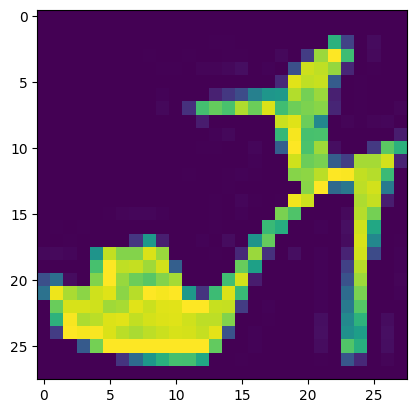

In [168]:
plt.imshow(np.array(df_trn.iloc[9, 1:]).reshape(28,28))

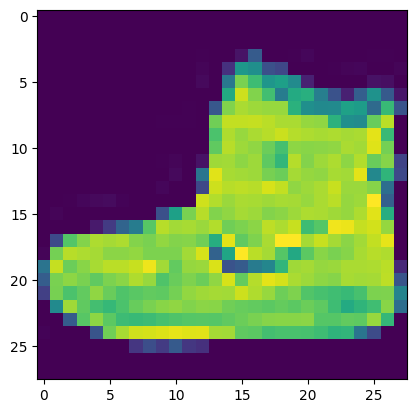

In [169]:
plt.imshow(np.array(df_trn[df_trn['label']==9].iloc[0, 1:]).reshape(28, 28))


## Load Data

- load dataframe.
- check for missing values.
- check for duplicated rows.

In [ ]:
# df_trn= pd.read_csv('fashion-mnist_train.csv')
# df_tst= pd.read_csv('fashion-mnist_test.csv')

In [14]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [15]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [ ]:
# train_labels= df_trn.iloc[:, 0].values
# train_images= df_trn.iloc[:, 1:].values/255.0

# test_labels= df_tst.iloc[:, 0].values
# test_images= df_tst.iloc[:, 1:].values/255.0

## Data Preprocessing

### Feature Extraction

In [17]:
X_trn= df_trn.drop('label', axis=1)
y_trn= df_trn['label']

X_tst= df_tst.drop('label', axis=1)
y_tst= df_tst['label']

### Scaling

In [ ]:
scaler= StandardScaler()

In [ ]:
X_trn= scaler.fit_transform(X_trn)
X_tst= scaler.transform(X_tst)

In [ ]:
# X_train, X_val, y_train, y_val= train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

## Model Training

In [ ]:
def model_report(model, verbose=True):
	hist= model.fit(X_trn, y_trn)

	y_pred=   model.predict(X_tst)
	trnScore= model.score(X_trn, y_trn)
	tstScore= model.score(X_tst, y_tst)
	accScore= accuracy_score(y_tst, y_pred)
	preScore= precision_score(y_tst, y_pred, average='macro')
	recScore= recall_score(y_tst, y_pred, average='macro')
	cm= confusion_matrix(y_tst, y_pred)
	# cr= classification_report(y_tst, y_pred)

	if verbose:
		print('Train Score: %f'%trnScore)
		print('Test Score:  %f'%tstScore)
		# print('Classification Report:\n', cr)
		print('Accuracy Score: %f'%accScore)
		print('Precision Score: %f'%preScore)
		print('Recall Score: %f'%recScore)

		ConfusionMatrixDisplay(cm).plot()
		plt.show()
		print()
	
	return {
		'trn':  trnScore,
		'tst':  tstScore,
		'acc':  accScore,
		'pre':  preScore,
		'rec':  recScore,
		'cm':   cm,
		'hist': hist
		# 'cr':  cr,
	}

In [22]:
models_dict= {
	'LogisticRegression':        LogisticRegression(max_iter=10_000, solver='lbfgs', multi_class='multinomial'),
	'KNeighborsClassifier':      KNeighborsClassifier(),
	# 'Support Vector Classifier': SVC(),
	# 'DecisionTreeClassifier':    DecisionTreeClassifier(),
	# 'RandomForestClassifier':    RandomForestClassifier(),
	# 'BaggingClassifier':         BaggingClassifier(),
	# 'ExtraTreesClassifier':      ExtraTreesClassifier(),
	# 'AdaBoostClassifier':        AdaBoostClassifier(),
	# 'XGBClassifier':             XGBClassifier(),
	# 'CatBoostClassifier':        CatBoostClassifier(verbose=False),
	# 'LGBMClassifier':            LGBMClassifier(),
}
models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

i= 0
for model in models:
	print("Evaluating %s..."%model['name'])
	print("%d/%d models"%(i, len(models)), end='\r')
	model.update(model_report(model['obj'], verbose=False))
	i+= 1
print("%d/%d models evaluated"%(i, len(models)))
print("done")

Evaluating LogisticRegression...


d:\Programs\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Programs\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating KNeighborsClassifier...
2/2 models evaluated
done



### LogisticRegression

In [ ]:
# logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
# logistic_model.fit(X_train, y_train)

# logistic_val_predictions = logistic_model.predict(X_val)
# logistic_test_predictions = logistic_model.predict(test_images)
# logistic_test_probabilities = logistic_model.predict_proba(test_images)

# logistic_val_accuracy = accuracy_score(y_val, logistic_val_predictions)
# logistic_test_accuracy = accuracy_score(test_labels, logistic_test_predictions)

# print(f'Logistic Regression Validation Accuracy: {logistic_val_accuracy:.4f}')
# print(f'Logistic Regression Test Accuracy: {logistic_test_accuracy:.4f}')

# logistic_conf_matrix = confusion_matrix(test_labels, logistic_test_predictions)
# print('Logistic Regression Confusion Matrix:')
# print(logistic_conf_matrix)

# logistic_precision = precision_score(test_labels, logistic_test_predictions, average='macro')
# logistic_recall = recall_score(test_labels, logistic_test_predictions, average='macro')

# print(f'Logistic Regression Precision: {logistic_precision:.4f}')
# print(f'Logistic Regression Recall: {logistic_recall:.4f}')


d:\Programs\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Validation Accuracy: 0.8500
Logistic Regression Test Accuracy: 0.8500
Logistic Regression Confusion Matrix:
[[819   2  19  38   2   4  99   0  17   0]
 [  2 974   1  14   1   2   6   0   0   0]
 [ 19   5 757  15 107   0  88   0   9   0]
 [ 37  23  19 857  28   0  26   1   9   0]
 [  1   1  81  34 798   0  80   0   5   0]
 [  1   4   0   0   1 915   0  51   5  23]
 [149   6 103  39  93   0 591   0  19   0]
 [  0   0   0   0   0  39   0 913   1  47]
 [  3   2   5   8   6   9  23   5 937   2]
 [  0   0   0   0   0  15   0  45   1 939]]
Logistic Regression Precision: 0.8483
Logistic Regression Recall: 0.8500


### KNNClassifier

In [ ]:
# knn_model = KNeighborsClassifier(n_neighbors=5)
# knn_model.fit(X_train, y_train)

# knn_val_predictions = knn_model.predict(X_val)
# knn_test_predictions = knn_model.predict(test_images)
# knn_test_probabilities = knn_model.predict_proba(test_images)

# knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)
# knn_test_accuracy = accuracy_score(test_labels, knn_test_predictions)

# print(f'KNN Validation Accuracy: {knn_val_accuracy:.4f}')
# print(f'KNN Test Accuracy: {knn_test_accuracy:.4f}')

# knn_conf_matrix = confusion_matrix(test_labels, knn_test_predictions)
# print('KNN Confusion Matrix:')
# print(knn_conf_matrix)

# knn_precision = precision_score(test_labels, knn_test_predictions, average='macro')
# knn_recall = recall_score(test_labels, knn_test_predictions, average='macro')

# print(f'KNN Precision: {knn_precision:.4f}')
# print(f'KNN Recall: {knn_recall:.4f}')

KNN Validation Accuracy: 0.8558
KNN Test Accuracy: 0.8543
KNN Confusion Matrix:
[[858   1  20  12   4   0  97   2   6   0]
 [  5 965   7  15   1   0   7   0   0   0]
 [ 18   1 794  11 103   0  72   0   1   0]
 [ 41  10  15 877  33   0  24   0   0   0]
 [  6   0 105  25 794   0  68   0   2   0]
 [  1   0   2   1   0 810   7 106   4  69]
 [209   1 111  19  69   0 581   0  10   0]
 [  0   0   0   0   0   2   0 947   0  51]
 [  4   1  16   3   6   1  10   5 951   3]
 [  0   0   0   0   0   3   0  31   0 966]]
KNN Precision: 0.8571
KNN Recall: 0.8543


## Model Evaluation

- loss curve.
- accuracy curve.
- confusion_matrix (precision, recall).
- ROC curve (AUC).

In [23]:
pd.DataFrame({
	'Algorithm':           [model['name'] for model in models],
	'Train Score':         [model['trn']  for model in models],
	'Test Score':          [model['tst']  for model in models],
	'Accuracy Score':      [model['acc']  for model in models],
	'Precision Score':     [model['pre']  for model in models],
	'Recall Score':        [model['rec']  for model in models],
}).set_index('Algorithm').sort_values(by='Test Score', ascending=False)

,Train Score,Test Score,Accuracy Score,Precision Score,Recall Score
Algorithm,,,,,
KNeighborsClassifier,0.899317,0.8589,0.8589,0.861394,0.8589
LogisticRegression,0.879117,0.8448,0.8448,0.843468,0.8448


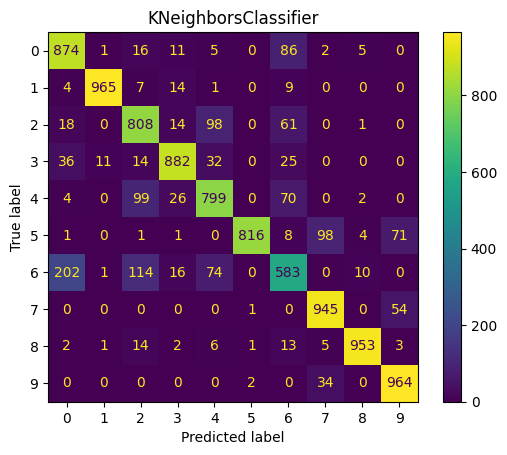

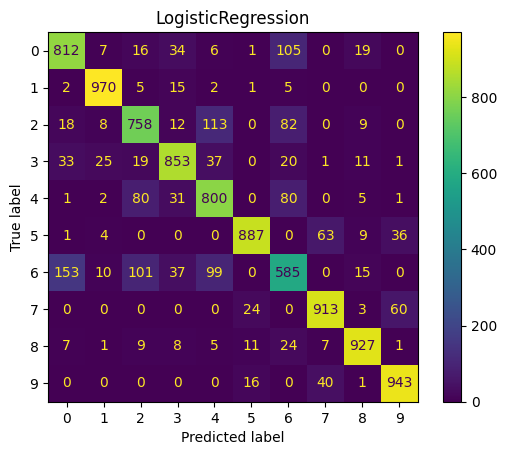

In [24]:
for model in sorted(models, key=lambda x: x['tst'], reverse=True):
	ConfusionMatrixDisplay(model['cm']).plot()
	plt.title(model['name'])

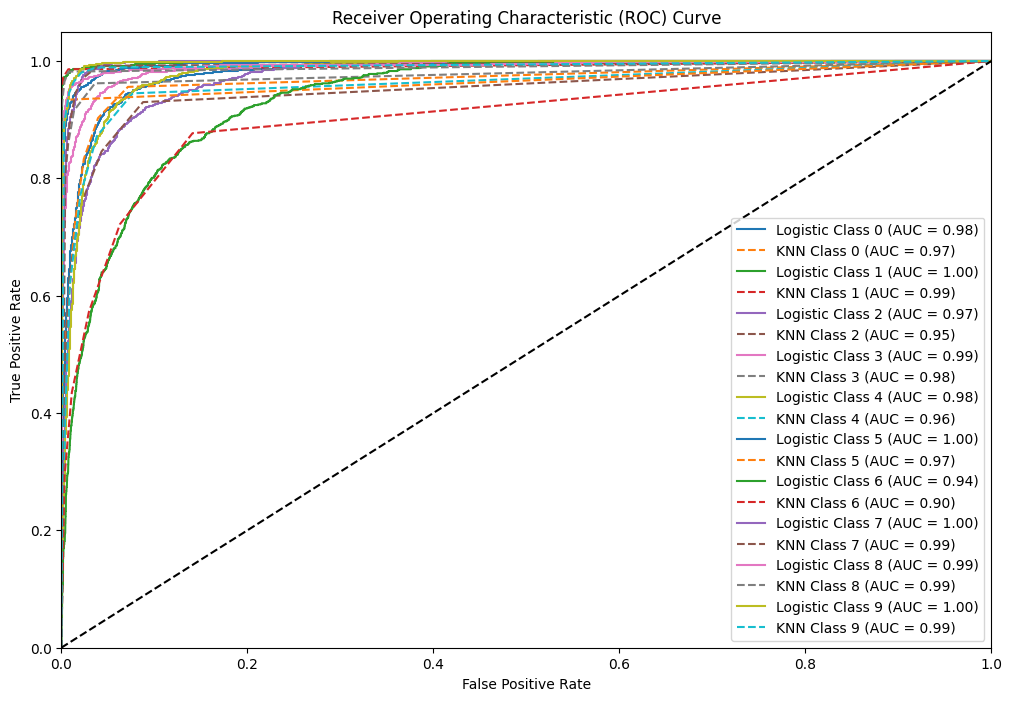

In [ ]:
# fpr_logistic = {}
# tpr_logistic = {}
# roc_auc_logistic = {}
# fpr_knn = {}
# tpr_knn = {}
# roc_auc_knn = {}

# for i in range(10):
#     fpr_logistic[i], tpr_logistic[i], _ = roc_curve(test_labels == i, logistic_test_probabilities[:, i])
#     roc_auc_logistic[i] = auc(fpr_logistic[i], tpr_logistic[i])
#     fpr_knn[i], tpr_knn[i], _ = roc_curve(test_labels == i, knn_test_probabilities[:, i])
#     roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# plt.figure(figsize=(12, 8))
# for i in range(10):
#     plt.plot(fpr_logistic[i], tpr_logistic[i], label=f'Logistic Class {i} (AUC = {roc_auc_logistic[i]:.2f})')
#     plt.plot(fpr_knn[i], tpr_knn[i], label=f'KNN Class {i} (AUC = {roc_auc_knn[i]:.2f})', linestyle='--')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


## Conclusion